# Collaboration and Competition

---

Project 3 of [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import importlib
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Self-created modules
import ddpg_agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. Train using DDPG

In [5]:
# Target parameters as provided in "The Environment - Introduction"-lesson
average_target_score = 0.5
average_episode_memory = 100

# Other parameters
update_time_unit = 2
noise = 1
noise_discount = 0.9999

Episode 100	Average Score: 0.00000
Episode 200	Average Score: 0.00360
Episode 300	Average Score: 0.03540
Episode 400	Average Score: 0.03870
Episode 500	Average Score: 0.03500
Episode 600	Average Score: 0.03300
Episode 700	Average Score: 0.04700
Episode 800	Average Score: 0.04890
Episode 900	Average Score: 0.04570
Episode 1000	Average Score: 0.04430
Episode 1100	Average Score: 0.05380
Episode 1200	Average Score: 0.05520
Episode 1300	Average Score: 0.07990
Episode 1400	Average Score: 0.10560
Episode 1500	Average Score: 0.10930
Episode 1600	Average Score: 0.12880
Episode 1700	Average Score: 0.19330
Episode 1800	Average Score: 0.21490
Episode 1872	Average Score: 0.52110
Environment solved in 1872 episodes!	Average Score: 0.52110


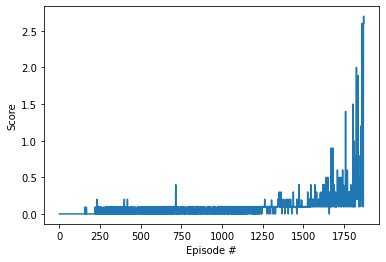

In [6]:
importlib.reload(ddpg_agent)

def ddpg(n_episodes=2000, 
         max_t=1000, 
         average_target_score = average_target_score,
         average_episode_memory=average_episode_memory, 
         n_states=state_size ,
         n_actions=action_size, 
         n_agents=num_agents,
         update_time_unit = update_time_unit,
         noise = noise,
         noise_discount = noise_discount
        ):
    
    scores_deque = deque(maxlen=average_episode_memory)
    scores = []
    
    # Initialize both agents
    agents = []
    for i_agent in range(n_agents):
        agents.append(ddpg_agent.Agent(n_states, n_actions, random_seed=0))

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        agent_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = [agents[i].act(states[i],noise) for i in range(n_agents)]
            actions = np.array(actions)
            
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done     
            
            if t % update_time_unit == 0:
                for i in range(num_agents):
                    agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) 

            states = next_states
            agent_scores += rewards            
            noise *= noise_discount
            
            if np.any(dones):
                break  
                
        score = np.max(agent_scores)
        scores_deque.append(score)
        scores.append(score) 
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.5f}', end="")
        if i_episode % average_episode_memory == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.5f}')  
        if np.mean(scores_deque)>=average_target_score:
            print(f'\nEnvironment solved in {i_episode:d} episodes!\tAverage Score: {np.mean(scores_deque):.5f}')
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break  
    return scores
        
    

scores = ddpg(n_episodes=5000, max_t=100000)
#scores = ddpg(n_episodes=2, max_t=100000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('./plots/plot_of_rewards.png', dpi=200)
plt.show()